In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
# import the necessary packages
from tensorflow.keras.layers import AveragePooling2D, Dropout, Flatten, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import optimizers, models, layers
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.resnet50 import ResNet50

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os

In [3]:
# set learning rate, epochs and batch size
INIT_LR = 1e-5    # This value is specific to what model is chosen: Inception, VGG or ResnNet.
EPOCHS = 50 
BS = 8

print("Loading images...")
imagePath = "./Covid_M/all/train"
imagePaths = list(paths.list_images(imagePath))

data = []
labels = []

# read all X-Rays in the specified path, and resize them all to 256x256
for imagePath in imagePaths:
    label = imagePath.split(os.path.sep)[-2]
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (256, 256))
    data.append(image)
    labels.append(label)
    
#normalise pixel values to real numbers between 0.0 - 1.0 
data = np.array(data) / 255.0
labels = np.array(labels)

# perform one-hot encoding for a 3-class labeling 
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(labels)
labels = to_categorical(integer_encoded)

print("... ... ", len(data), "images loaded in 3x classes:")
print(label_encoder.classes_)

Loading images...
... ...  200 images loaded in 3x classes:
['covid' 'normal' 'pneumonia_bac']


In [4]:
# split the data between train and validation.
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.20, stratify=labels, random_state=42)

# add on a simple Augmentation. Note: too many Augumentation doesn't actually help in this case - I found during the test. 
trainAug = ImageDataGenerator(rotation_range=15, fill_mode="nearest")

#Use the InveptionV3 model with Transfer Learning of pre-trained "ImageNet"'s weights.
#note: If you choose VGG16 or ResNet you may need to reset the initial learning rate at the top.
baseModel = InceptionV3(weights="imagenet", include_top=False, input_tensor=Input(shape=(256, 256, 3)))
#baseModel = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(256, 256, 3)))
#baseModel = ResNet50(weights="imagenet", include_top=False, input_tensor=Input(shape=(256, 256, 3)))

#Add on a couple of custom CNN layers on top of the Inception V3 model. 
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(3, activation="softmax")(headModel)

# Compose the final model
model = Model(inputs=baseModel.input, outputs=headModel)

# Unfreeze pre-trained Inception "ImageNet" weights for re-training since I got a Navidia T5 GPU to play with anyway

#for layer in baseModel.layers:
#    layer.trainable = False

print("Compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

# train the head of the network
print("Training the full stack model...")
H = model.fit_generator( trainAug.flow(trainX, trainY, batch_size=BS), steps_per_epoch=len(trainX) // BS,
                         validation_data=(testX, testY), validation_steps=len(testX) // BS, epochs=EPOCHS)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Compiling model...
Training the full stack model...
Instructions for updating:
Use tf.cast instead.
Epoch 1/50
20/20 [==============================] - 16s 800ms/step - loss: 1.1971 - acc: 0.3812 - val_loss: 1.1898 - val_acc: 0.3000
Epoch 2/50
20/20 [==============================] - 3s 143ms/step - loss: 1.0693 - acc: 0.4688 - val_loss: 1.1483 - val_acc: 0.3750
Epoch 3/50
20/20 [==============================] - 3s 148ms/step - loss: 0.9861 - acc: 0.5000 - val_loss: 1.0196 - val_acc: 0.4500
Epoch 4/50
20/20 [==============================] - 3s 144ms/step - loss: 0.8517 - acc: 0.5813 - val_loss: 0.9102 - val_acc: 0.5500
Epoch 5/50
20/20 [==============================] - 3s 148ms/step - loss: 0.8039 - acc: 0.6000 - val_loss: 0.8196 - val_acc: 0.6500
Epoch 6/50
20/20 [==============================] - 

Evaluating the trained model ...
               precision    recall  f1-score   support

        covid       1.00      1.00      1.00        12
       normal       1.00      0.93      0.96        14
pneumonia_bac       0.93      1.00      0.97        14

     accuracy                           0.97        40
    macro avg       0.98      0.98      0.98        40
 weighted avg       0.98      0.97      0.97        40

[[12  0  0]
 [ 0 13  1]
 [ 0  0 14]]
acc: 0.9750
sensitivity: 1.0000
specificity: 1.0000


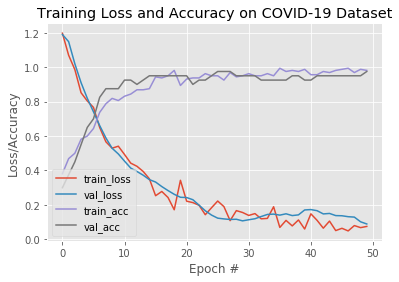

In [5]:
print("Evaluating the trained model ...")
preds = model.predict(testX, batch_size=BS)

preds = np.argmax(preds, axis=1)

print(classification_report(testY.argmax(axis=1), preds, target_names=label_encoder.classes_))

# calculate a basic confusion matrix 
cm = confusion_matrix(testY.argmax(axis=1), preds)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1] + cm[2, 2]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1] + cm[0, 2])
specificity = (cm[1, 1] + cm[1, 2] + cm[2, 1] + cm[2, 2]) / (cm[1, 0] + cm[1, 1] + cm[1, 2] + cm[2, 0] + cm[2, 1] + cm[2, 2])

# show the confusion matrix, accuracy, sensitivity, and specificity
print(cm)
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

# plot the training loss and accuracy
N = EPOCHS 
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy on COVID-19 Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("./Covid19/s-class-plot.png")

In [6]:
print("[INFO] loading untrained test images...")
imagePathTest = "./Covid_M/all/test"
imagePathsTest = list(paths.list_images(imagePathTest))
print(len(imagePathsTest))

dataTest = []
labelsTest = []

# loop over the image paths
for imagePathTest in imagePathsTest:

    # extract the class label from the filename
	  labelTest = imagePathTest.split(os.path.sep)[-2]
  
	  # load the image, swap color channels, and resize it to be a fixed
	  # 256x256 pixels while ignoring aspect ratio
	  imageTest = cv2.imread(imagePathTest)
	  imageTest = cv2.cvtColor(imageTest, cv2.COLOR_BGR2RGB)
	  imageTest = cv2.resize(imageTest, (256, 256))

	  # update the data and labels lists, respectively
	  dataTest.append(imageTest)
	  labelsTest.append(labelTest)
# convert the data and labels to NumPy arrays while scaling the pixel
# intensities to the range [0, 255]
dataTest = np.array(dataTest) / 255.0
labelsTest = np.array(labelsTest)


# perform one-hot encoding on the labels
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(labelsTest)
labelsTest = to_categorical(integer_encoded)

print(labelsTest)

[INFO] loading untrained test images...
27
[[0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]]


In [7]:
predTest = model.predict(dataTest, batch_size=BS)

print(predTest)

[[1.16182650e-02 9.31305438e-02 8.95251155e-01]
 [1.16804927e-06 3.32693919e-04 9.99666095e-01]
 [1.62126590e-02 7.63820077e-04 9.83023584e-01]
 [4.78882110e-03 2.33179983e-02 9.71893132e-01]
 [2.83091445e-03 9.68348584e-04 9.96200740e-01]
 [2.20730919e-02 7.30762025e-04 9.77196097e-01]
 [3.48773989e-04 9.42261249e-04 9.98708963e-01]
 [5.39726764e-02 3.56335193e-03 9.42463994e-01]
 [9.53383930e-03 2.01038853e-03 9.88455772e-01]
 [9.91809905e-01 8.53908859e-05 8.10475741e-03]
 [9.37188327e-01 3.03508714e-03 5.97764999e-02]
 [9.98324573e-01 2.29492565e-04 1.44601660e-03]
 [9.98400748e-01 2.70507910e-04 1.32874143e-03]
 [9.94811773e-01 1.59044762e-03 3.59782577e-03]
 [9.71176088e-01 1.86337437e-02 1.01902047e-02]
 [9.99527097e-01 5.56778577e-05 4.17279400e-04]
 [9.96674538e-01 2.01867009e-03 1.30681146e-03]
 [8.85348678e-01 2.50480860e-03 1.12146445e-01]
 [1.55448088e-05 1.67850837e-01 8.32133591e-01]
 [4.26065744e-05 9.75556254e-01 2.44012251e-02]
 [6.23177548e-05 9.82340813e-01 1.759692

In [15]:
predClasses = predTest.argmax(axis=-1)
print(predClasses)

[2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 2 1 1 1 1 1 1 1 1]


In [17]:
# make predictions on the testing set
print("Evaluating real test samples ...")

testX = dataTest
testY = labelsTest

predIdxs = model.predict(testX, batch_size=BS)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=label_encoder.classes_))

# compute the confusion matrix and and use it to derive the raw
# accuracy, sensitivity, and specificity
cm = confusion_matrix(testY.argmax(axis=1), predIdxs)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1] + cm[2, 2]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1] + cm[0, 2])
specificity = (cm[1, 1] + cm[1, 2] + cm[2, 1] + cm[2, 2]) / (cm[1, 0] + cm[1, 1] + cm[1, 2] + cm[2, 0] + cm[2, 1] + cm[2, 2])

# show the confusion matrix, accuracy, sensitivity, and specificity
print(cm)
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

Evaluating real test samples ...
               precision    recall  f1-score   support

        covid       1.00      1.00      1.00         9
       normal       1.00      0.89      0.94         9
pneumonia_bac       0.90      1.00      0.95         9

     accuracy                           0.96        27
    macro avg       0.97      0.96      0.96        27
 weighted avg       0.97      0.96      0.96        27

[[9 0 0]
 [0 8 1]
 [0 0 9]]
acc: 0.9630
sensitivity: 1.0000
specificity: 1.0000
